In [5]:
!pip install keras-tuner


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import numpy as np
import os
import tqdm
import pandas as pd
import keras
import time, warnings
import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import KFold, train_test_split, LeaveOneGroupOut, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    Activation,
    GlobalAveragePooling2D,
)
from tensorflow.keras.applications import DenseNet121, DenseNet201, DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore")


In [8]:

#class for plotting
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def normalize(clip):
    normalized_clip = (clip - np.min(clip)) / (np.max(clip) - np.min(clip))
    return normalized_clip

def conv_array(root_folder):
    metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_3/processed_data.csv')
    folds = {}
    for fold in range(1, 11):
        fold_path = os.path.join(root_folder, f"fold{fold}")
        image_data = []
        all_labels = []
        if not os.path.exists(fold_path):
            continue  # Skip if the folder doesn't exist
        for filename in tqdm.tqdm(os.listdir(fold_path)):
            if filename.endswith(".png"):
                image_path = os.path.join(fold_path, filename)
                image = Image.open(image_path)
                new_filename = filename.replace('.png', '.wav')
                row_num = metadata[metadata['slice_file_name'] == new_filename].index
                if not row_num.empty:
                    image_array = np.array(image)
                    if not image_array.shape == (76, 33):
                      continue
                    image_array = normalize(image_array)
                    #image_array = tensorflow.image.grayscale_to_rgb(image_array)
                    #print(image_array.shape)
                    image_array = np.ndarray(shape=(image_array.shape[0], image_array.shape[1], 1), dtype= np.uint8)
                    label = metadata.iloc[row_num]['labelID'].values[0]
                    #print(f'Double check: image {new_filename} has label {label}')
                    all_labels.append(label)
                    image_data.append(image_array)
                else:
                    print(f'{new_filename} not found')
                    continue
        image_data = np.array(image_data)
        #print(image_data)
        all_labels = np.array(all_labels)
        all_labels = to_categorical(all_labels, num_classes=10)
        #converting numpy arrays to tf.tensor for GPU optimization
        image_data_tensor = tensorflow.convert_to_tensor(image_data)
        all_labels_tensor = tensorflow.convert_to_tensor(all_labels)
        #print(image_data_tensor)
        image_data_tensor = tensorflow.image.grayscale_to_rgb(image_data_tensor)
        folds[f"fold{fold}"] = [image_data_tensor, all_labels_tensor]
    return folds


root_folder = r"/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_3/both"
data = conv_array(root_folder)
input_shape = data['fold1'][0].shape
#input_shape = input_shape + (3,)
print(input_shape)

100%|██████████| 529/529 [00:17<00:00, 31.08it/s] 


(542, 76, 33, 3)


In [9]:
print(input_shape)
input_shape2 = input_shape[1:4]
print(input_shape2)

(542, 76, 33, 3)
(76, 33, 3)


  0%|          | 0/10 [00:00<?, ?it/s]

Training using fold1 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.91122, saving model to model.h5
26/26 - 31s - loss: 2.0743 - accuracy: 0.3996 - val_loss: 2.9112 - val_accuracy: 0.3081 - lr: 0.0010 - 31s/epoch - 1s/step
Epoch 2/30

Epoch 2: val_loss improved from 2.91122 to 2.03978, saving model to model.h5
26/26 - 4s - loss: 1.3948 - accuracy: 0.5517 - val_loss: 2.0398 - val_accuracy: 0.4170 - lr: 0.0010 - 4s/epoch - 161ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.03978 to 1.84222, saving model to model.h5
26/26 - 3s - loss: 1.2496 - accuracy: 0.5991 - val_loss: 1.8422 - val_accuracy: 0.4244 - lr: 0.0010 - 3s/epoch - 99ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.84222 to 1.65324, saving model to model.h5
26/26 - 3s - loss: 1.1098 - accuracy: 0.6363 - val_loss: 1.6532 - val_accuracy: 0.4982 - lr: 0.0010 - 3s/epoch - 101ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.65324 to 1.47088, saving model to model.h5
26/26 - 3s - loss: 1.0529 - ac

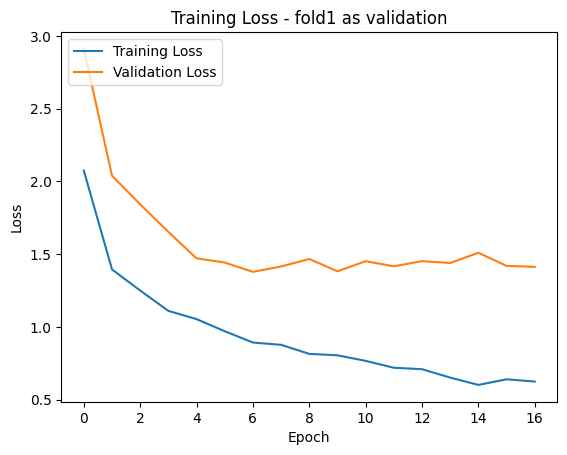

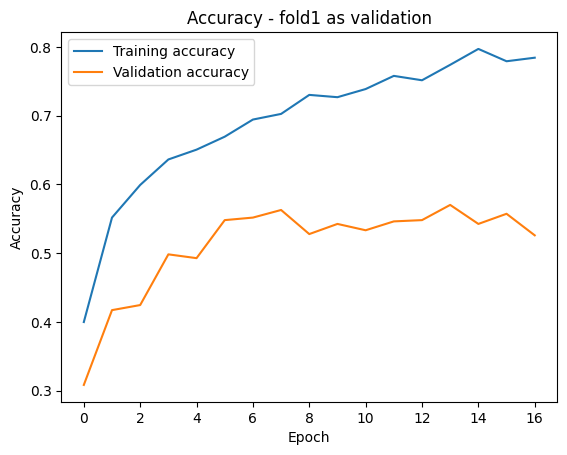

 10%|█         | 1/10 [01:28<13:17, 88.64s/it]

Training using fold2 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.00436, saving model to model.h5
30/30 - 22s - loss: 2.0076 - accuracy: 0.4297 - val_loss: 3.0044 - val_accuracy: 0.3000 - lr: 0.0010 - 22s/epoch - 730ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.00436 to 2.05070, saving model to model.h5
30/30 - 5s - loss: 1.4361 - accuracy: 0.5518 - val_loss: 2.0507 - val_accuracy: 0.3000 - lr: 0.0010 - 5s/epoch - 173ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.05070 to 1.68101, saving model to model.h5
30/30 - 3s - loss: 1.1778 - accuracy: 0.6058 - val_loss: 1.6810 - val_accuracy: 0.4000 - lr: 0.0010 - 3s/epoch - 105ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.68101 to 1.19964, saving model to model.h5
30/30 - 3s - loss: 1.1311 - accuracy: 0.6327 - val_loss: 1.1996 - val_accuracy: 0.4000 - lr: 0.0010 - 3s/epoch - 88ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.19964
30/30 - 1s - loss: 1.0245 - accuracy: 0.6576 - val_loss: 

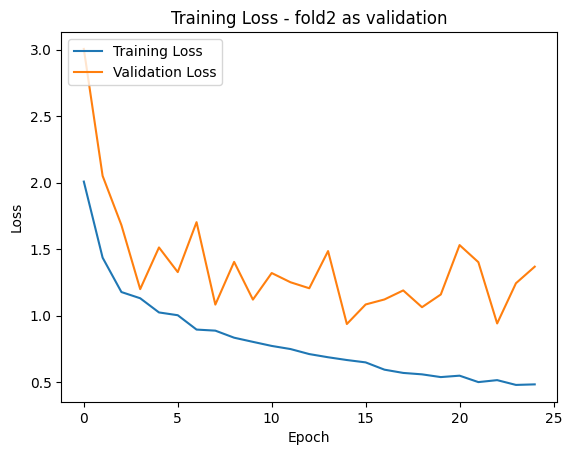

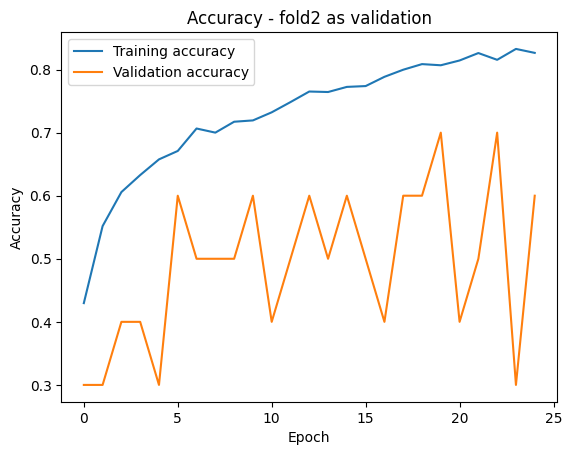

 20%|██        | 2/10 [03:19<13:31, 101.48s/it]

Training using fold3 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.68957, saving model to model.h5
30/30 - 20s - loss: 2.0239 - accuracy: 0.4227 - val_loss: 3.6896 - val_accuracy: 0.3000 - lr: 0.0010 - 20s/epoch - 651ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.68957 to 2.69194, saving model to model.h5
30/30 - 3s - loss: 1.3518 - accuracy: 0.5699 - val_loss: 2.6919 - val_accuracy: 0.4000 - lr: 0.0010 - 3s/epoch - 111ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.69194 to 2.22308, saving model to model.h5
30/30 - 3s - loss: 1.2233 - accuracy: 0.6120 - val_loss: 2.2231 - val_accuracy: 0.3000 - lr: 0.0010 - 3s/epoch - 93ms/step
Epoch 4/30

Epoch 4: val_loss improved from 2.22308 to 1.97180, saving model to model.h5
30/30 - 3s - loss: 1.1144 - accuracy: 0.6442 - val_loss: 1.9718 - val_accuracy: 0.5000 - lr: 0.0010 - 3s/epoch - 88ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.97180 to 1.91775, saving model to model.h5
30/30 - 3s - loss: 1.0317 - 

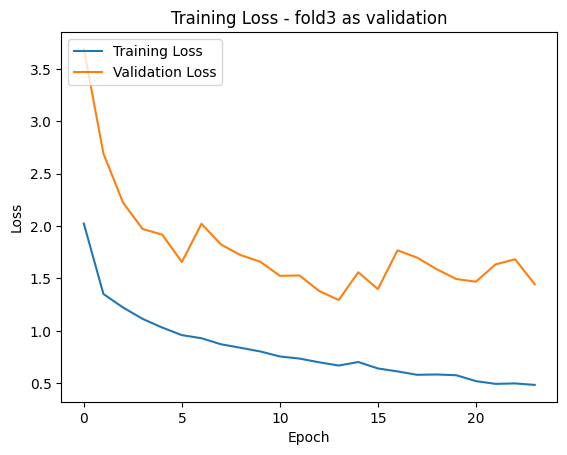

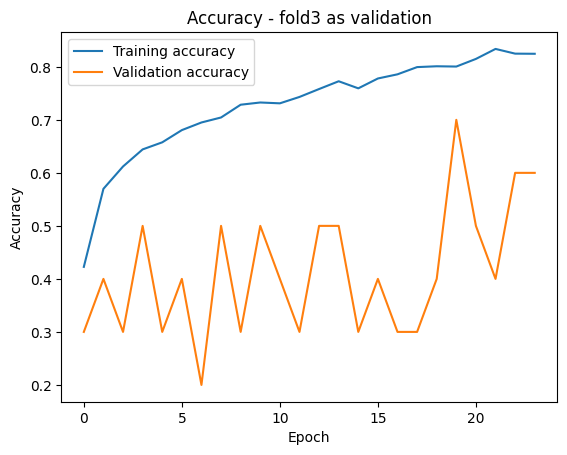

 30%|███       | 3/10 [04:37<10:37, 91.01s/it] 

Training using fold4 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.56744, saving model to model.h5
29/29 - 21s - loss: 1.9844 - accuracy: 0.4318 - val_loss: 3.5674 - val_accuracy: 0.2581 - lr: 0.0010 - 21s/epoch - 725ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.56744 to 2.15744, saving model to model.h5
29/29 - 5s - loss: 1.4030 - accuracy: 0.5604 - val_loss: 2.1574 - val_accuracy: 0.3952 - lr: 0.0010 - 5s/epoch - 165ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.15744 to 2.07671, saving model to model.h5
29/29 - 3s - loss: 1.1868 - accuracy: 0.6182 - val_loss: 2.0767 - val_accuracy: 0.4435 - lr: 0.0010 - 3s/epoch - 89ms/step
Epoch 4/30

Epoch 4: val_loss improved from 2.07671 to 1.79262, saving model to model.h5
29/29 - 3s - loss: 1.0684 - accuracy: 0.6506 - val_loss: 1.7926 - val_accuracy: 0.4839 - lr: 0.0010 - 3s/epoch - 89ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.79262
29/29 - 1s - loss: 1.0161 - accuracy: 0.6692 - val_loss: 2

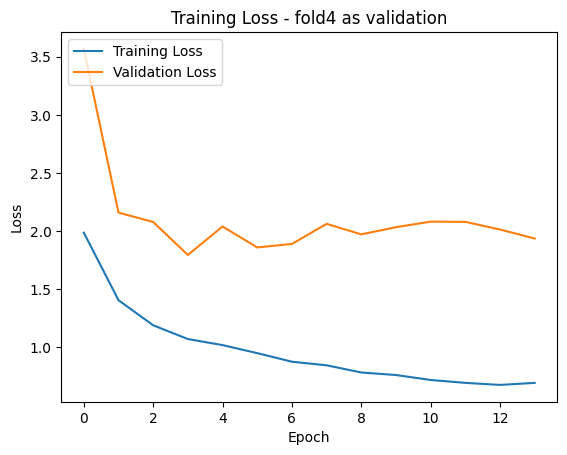

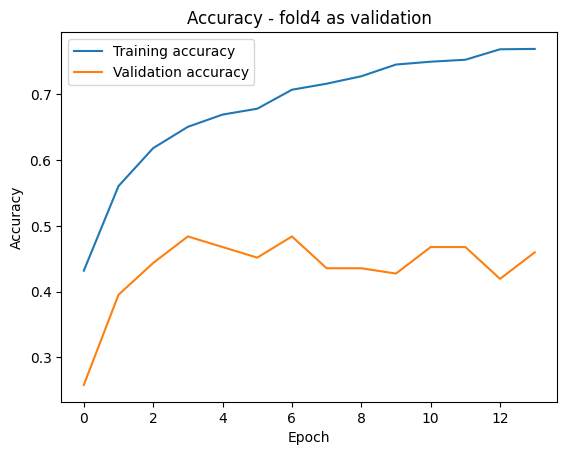

 40%|████      | 4/10 [05:40<08:00, 80.03s/it]

Training using fold5 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.07124, saving model to model.h5
27/27 - 21s - loss: 1.9974 - accuracy: 0.4230 - val_loss: 3.0712 - val_accuracy: 0.2795 - lr: 0.0010 - 21s/epoch - 779ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.07124 to 2.44009, saving model to model.h5
27/27 - 5s - loss: 1.3584 - accuracy: 0.5769 - val_loss: 2.4401 - val_accuracy: 0.3663 - lr: 0.0010 - 5s/epoch - 171ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.44009 to 1.86960, saving model to model.h5
27/27 - 3s - loss: 1.1891 - accuracy: 0.6208 - val_loss: 1.8696 - val_accuracy: 0.3928 - lr: 0.0010 - 3s/epoch - 97ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.86960 to 1.72526, saving model to model.h5
27/27 - 3s - loss: 1.1188 - accuracy: 0.6551 - val_loss: 1.7253 - val_accuracy: 0.4169 - lr: 0.0010 - 3s/epoch - 95ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.72526 to 1.55862, saving model to model.h5
27/27 - 3s - loss: 0.9708 - 

13/13 [==============================] - 4s 37ms/step


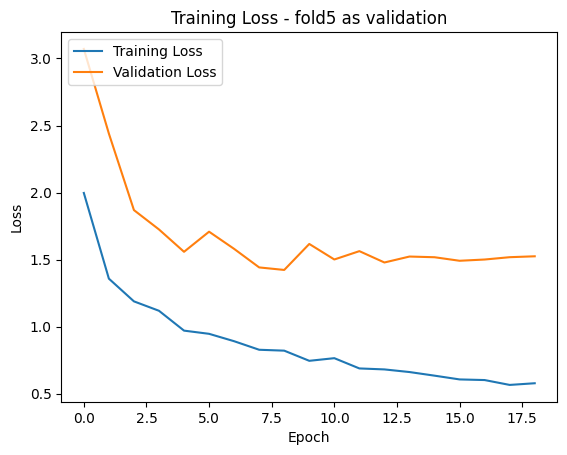

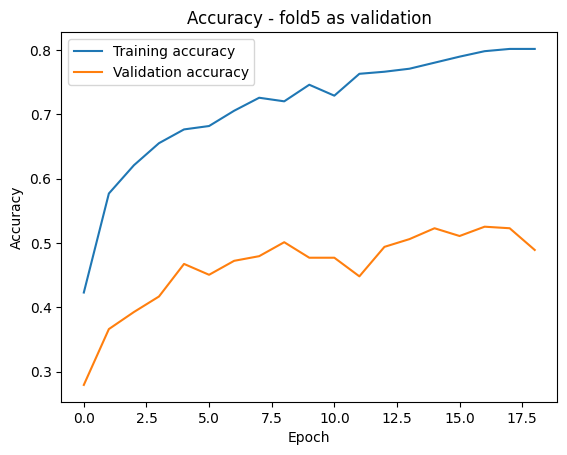

 50%|█████     | 5/10 [06:54<06:27, 77.59s/it]

Training using fold6 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.40900, saving model to model.h5
27/27 - 20s - loss: 1.9828 - accuracy: 0.4245 - val_loss: 3.4090 - val_accuracy: 0.2484 - lr: 0.0010 - 20s/epoch - 751ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.40900 to 2.57735, saving model to model.h5
27/27 - 5s - loss: 1.3865 - accuracy: 0.5683 - val_loss: 2.5773 - val_accuracy: 0.3313 - lr: 0.0010 - 5s/epoch - 175ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.57735 to 2.03780, saving model to model.h5
27/27 - 3s - loss: 1.1893 - accuracy: 0.6235 - val_loss: 2.0378 - val_accuracy: 0.4203 - lr: 0.0010 - 3s/epoch - 114ms/step
Epoch 4/30

Epoch 4: val_loss improved from 2.03780 to 1.98052, saving model to model.h5
27/27 - 3s - loss: 1.0817 - accuracy: 0.6436 - val_loss: 1.9805 - val_accuracy: 0.4369 - lr: 0.0010 - 3s/epoch - 99ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.98052 to 1.83528, saving model to model.h5
27/27 - 3s - loss: 1.0453 -

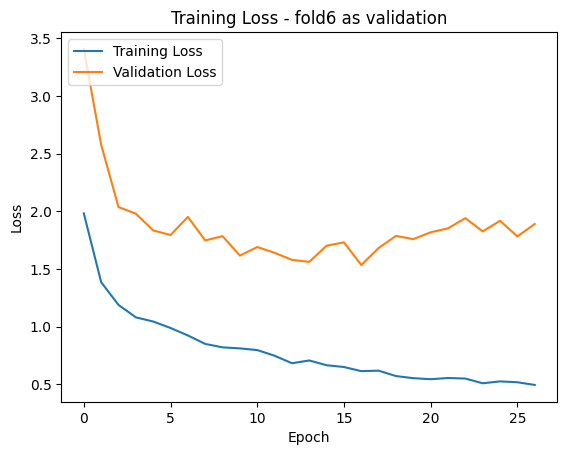

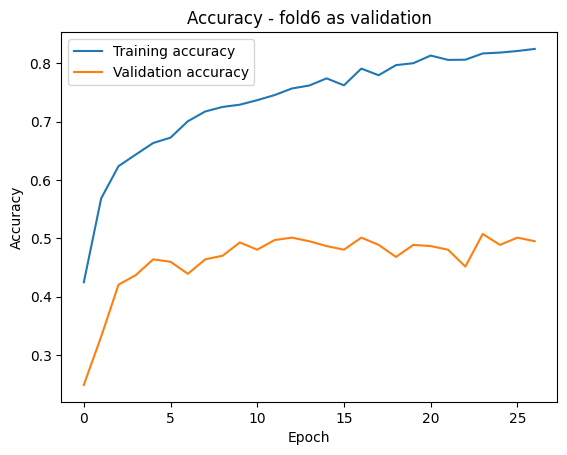

 60%|██████    | 6/10 [08:26<05:30, 82.58s/it]

Training using fold7 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.39177, saving model to model.h5
24/24 - 20s - loss: 2.0146 - accuracy: 0.4290 - val_loss: 3.3918 - val_accuracy: 0.2255 - lr: 0.0010 - 20s/epoch - 838ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.39177 to 2.67246, saving model to model.h5
24/24 - 4s - loss: 1.3716 - accuracy: 0.5712 - val_loss: 2.6725 - val_accuracy: 0.2852 - lr: 0.0010 - 4s/epoch - 187ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.67246 to 2.21819, saving model to model.h5
24/24 - 3s - loss: 1.2236 - accuracy: 0.6160 - val_loss: 2.2182 - val_accuracy: 0.4010 - lr: 0.0010 - 3s/epoch - 128ms/step
Epoch 4/30

Epoch 4: val_loss improved from 2.21819 to 2.14240, saving model to model.h5
24/24 - 3s - loss: 1.0889 - accuracy: 0.6310 - val_loss: 2.1424 - val_accuracy: 0.3508 - lr: 0.0010 - 3s/epoch - 112ms/step
Epoch 5/30

Epoch 5: val_loss improved from 2.14240 to 2.04214, saving model to model.h5
24/24 - 3s - loss: 0.9754 

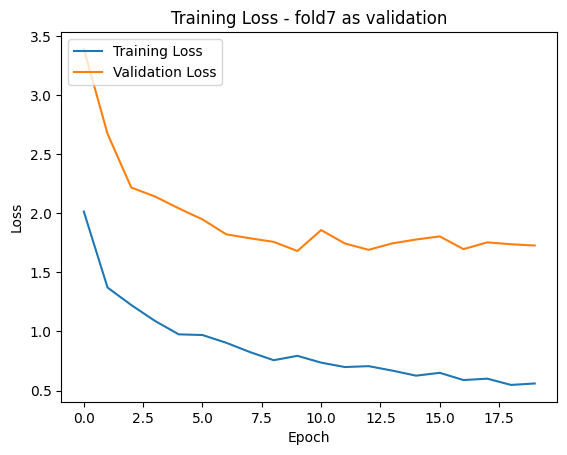

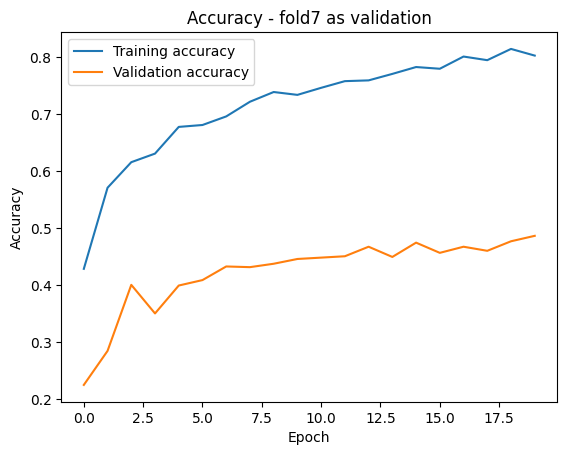

 70%|███████   | 7/10 [10:17<04:36, 92.02s/it]

Training using fold8 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.93982, saving model to model.h5
29/29 - 21s - loss: 1.9906 - accuracy: 0.4278 - val_loss: 2.9398 - val_accuracy: 0.2723 - lr: 0.0010 - 21s/epoch - 718ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.93982 to 1.89613, saving model to model.h5
29/29 - 5s - loss: 1.4056 - accuracy: 0.5628 - val_loss: 1.8961 - val_accuracy: 0.3770 - lr: 0.0010 - 5s/epoch - 159ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.89613 to 1.69790, saving model to model.h5
29/29 - 3s - loss: 1.2157 - accuracy: 0.6123 - val_loss: 1.6979 - val_accuracy: 0.4031 - lr: 0.0010 - 3s/epoch - 88ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 1.69790
29/29 - 1s - loss: 1.1085 - accuracy: 0.6367 - val_loss: 1.7126 - val_accuracy: 0.4031 - lr: 0.0010 - 1s/epoch - 49ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.69790 to 1.57979, saving model to model.h5
29/29 - 3s - loss: 1.0263 - accuracy: 0.6697 - val_loss: 1

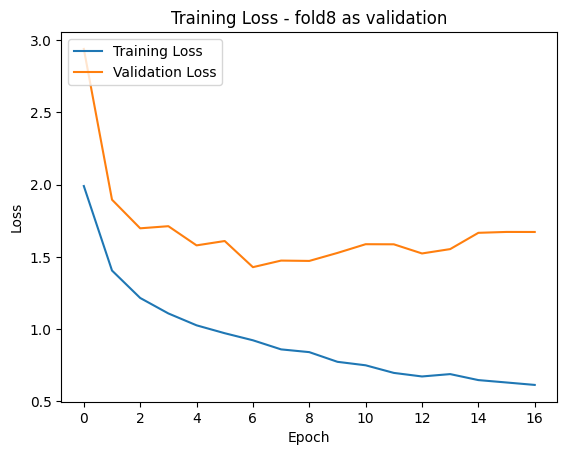

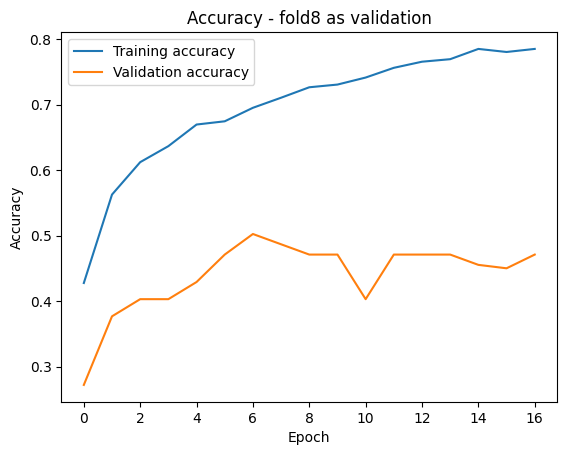

 80%|████████  | 8/10 [11:24<02:47, 83.90s/it]

Training using fold9 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.54593, saving model to model.h5
24/24 - 19s - loss: 2.1269 - accuracy: 0.4102 - val_loss: 3.5459 - val_accuracy: 0.2855 - lr: 0.0010 - 19s/epoch - 796ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.54593 to 1.94936, saving model to model.h5
24/24 - 3s - loss: 1.4656 - accuracy: 0.5418 - val_loss: 1.9494 - val_accuracy: 0.4583 - lr: 0.0010 - 3s/epoch - 111ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.94936 to 1.84063, saving model to model.h5
24/24 - 3s - loss: 1.2513 - accuracy: 0.5992 - val_loss: 1.8406 - val_accuracy: 0.4926 - lr: 0.0010 - 3s/epoch - 105ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.84063 to 1.58253, saving model to model.h5
24/24 - 3s - loss: 1.1718 - accuracy: 0.6228 - val_loss: 1.5825 - val_accuracy: 0.5343 - lr: 0.0010 - 3s/epoch - 108ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.58253
24/24 - 1s - loss: 1.0688 - accuracy: 0.6656 - val_loss:

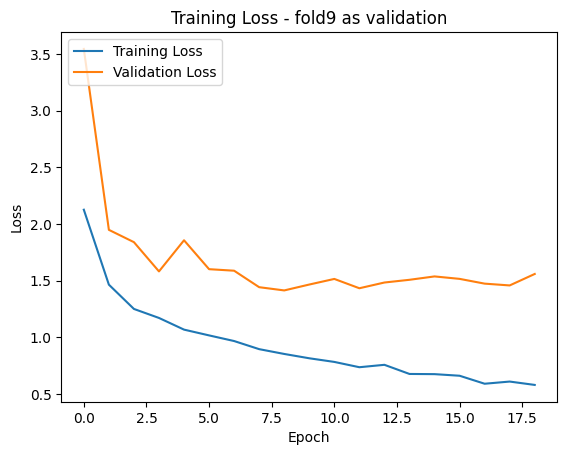

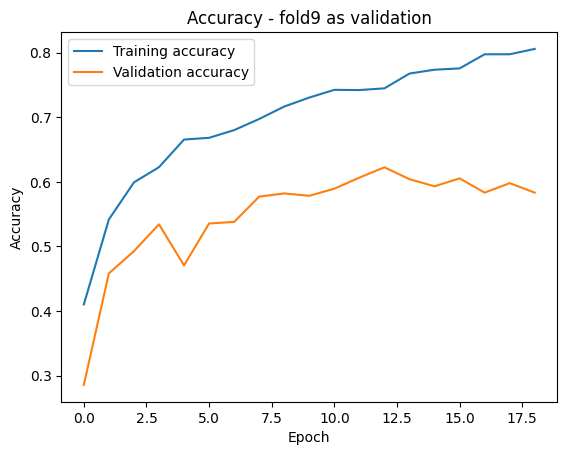

 90%|█████████ | 9/10 [13:11<01:31, 91.22s/it]

Training using fold10 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.25789, saving model to model.h5
26/26 - 21s - loss: 2.1174 - accuracy: 0.4168 - val_loss: 2.2579 - val_accuracy: 0.3856 - lr: 0.0010 - 21s/epoch - 790ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 2.25789
26/26 - 4s - loss: 1.3936 - accuracy: 0.5629 - val_loss: 2.3156 - val_accuracy: 0.3459 - lr: 0.0010 - 4s/epoch - 138ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.25789 to 1.84536, saving model to model.h5
26/26 - 3s - loss: 1.2053 - accuracy: 0.6180 - val_loss: 1.8454 - val_accuracy: 0.4386 - lr: 0.0010 - 3s/epoch - 122ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.84536 to 1.67894, saving model to model.h5
26/26 - 3s - loss: 1.0950 - accuracy: 0.6422 - val_loss: 1.6789 - val_accuracy: 0.5104 - lr: 0.0010 - 3s/epoch - 106ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.67894 to 1.45067, saving model to model.h5
26/26 - 3s - loss: 1.0062 - accuracy: 0.6704 - val_loss

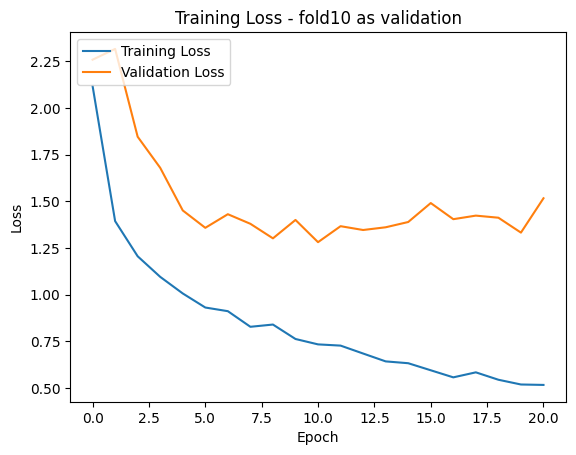

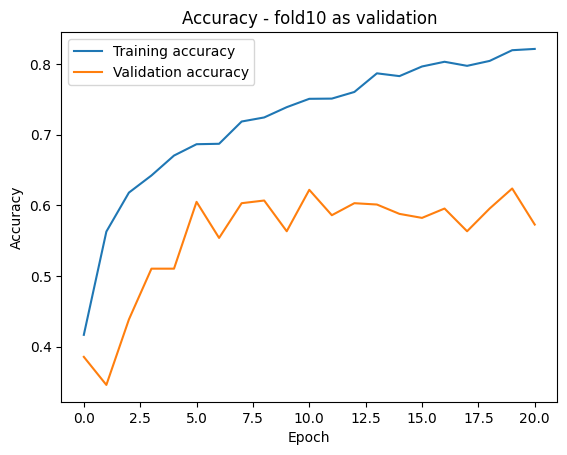

100%|██████████| 10/10 [15:02<00:00, 90.21s/it]


List of scores[0.5258302688598633, 0.6000000238418579, 0.6000000238418579, 0.45967742800712585, 0.4891566336154938, 0.49482402205467224, 0.4868735074996948, 0.4712041914463043, 0.5833333134651184, 0.5727788209915161]
Average accuracy: 0.5283678233623504
Trained only the last -8 layers


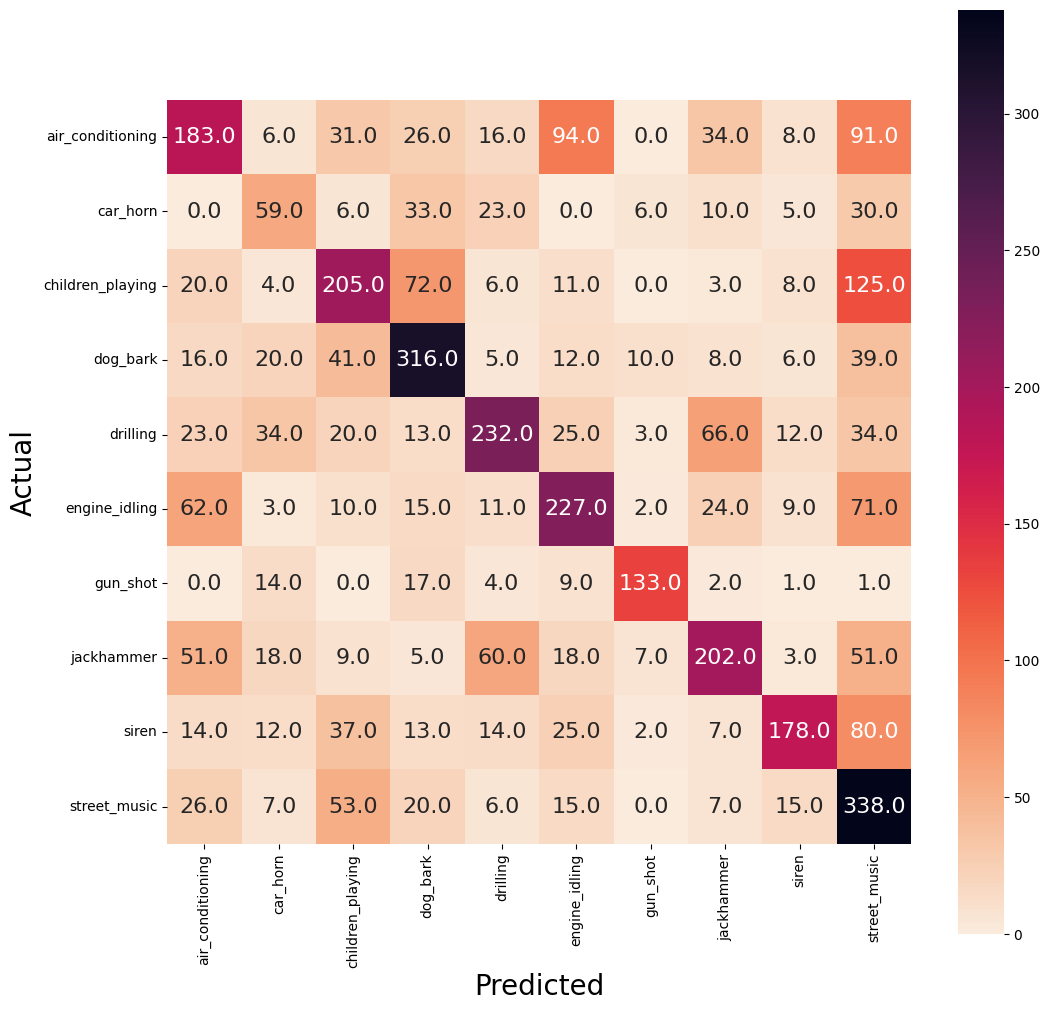

In [13]:
tensorflow.keras.backend.clear_session()

metric = 'accuracy' #evaluation metric
#metric = tensorflow.keras.metrics.MeanAveragePrecisionMetric(topn=2)
loss= 'categorical_crossentropy' #loss function

#training parameters
num_epoch = 30
batch_size = 128
early_stop = 10 # early stoppping after 3 epochs with no improvement of test data
#trainable layers needs a minus infront
trainable_layers = -8
dropout_rate = 0.5
learning_rate = 0.001


def model_k_cross(data):
    list_scores = []
    Ytrue_list = []
    Ypred_list = []
    for fold_name, fold_data in tqdm.tqdm(data.items()):
        tensorflow.keras.backend.clear_session()

        #Densenet121 model using pretrained weights from imagenet
        model_d=DenseNet201(weights='imagenet',include_top=False, input_shape=input_shape[1:4], classes=10)

        x=model_d.output
        x= GlobalAveragePooling2D()(x)
        x= BatchNormalization()(x)
        x= Dropout(dropout_rate)(x)
        x= Dense(1024,activation='relu')(x)
        x= Dense(512,activation='relu')(x)
        x= BatchNormalization()(x)
        x= Dropout(dropout_rate)(x)
        preds=Dense(10,activation='softmax')(x) #FC-layer
        model=Model(inputs=model_d.input,outputs=preds)

        #instance of Adam optimizer
        Adam = keras.optimizers.Adam(learning_rate=learning_rate)


        #To avoid the problem of overfitting, avoid training the entire network. layer.trainable=False will freeze all the layers, keeping only the last eight layers (FC) to detect edges and blobs in the image. Once the model is fitted well, it can be fine-tuned by using layer.trainable=True.
        for layer in model.layers[:trainable_layers]:
            layer.trainable=False
        for layer in model.layers[trainable_layers:]:
            layer.trainable=True


        print(f"Training using {fold_name} as validation")
        X_val, y_val = fold_data[0], fold_data[1]
        X_train = []
        y_train = []

        for other_fold_name, other_fold_data in data.items():
            if other_fold_name == fold_name:
                continue

            X = other_fold_data[0]
            y = other_fold_data[1]
            X_train.extend(X)
            y_train.extend(y)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        model.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
        EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)


        #If the model sees no change in validation loss the ReduceLROnPlateau function will reduce the learning rate, which often benefits the model.
        anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
        checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)


        history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                       steps_per_epoch=X_train.shape[0] //128,
                       epochs=num_epoch,
                       verbose=2,
                       callbacks=[anne, checkpoint, EarlyStoppingCallback],
                       validation_data=(X_val, y_val))

        # Evaluation
        scores = model.evaluate(X_val, y_val)
        print("Validation accuracy:", scores[1])
        list_scores.append(scores[1])

        Ypred_it = model.predict(X_val)
        Ypred_it = np.argmax(Ypred_it, axis=1)
        Ytrue_it = np.argmax(y_val, axis=1)
        Ytrue_list.extend(Ytrue_it.tolist())  # Append predictions to lists
        Ypred_list.extend(Ypred_it.tolist())


        # Plot training history - loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f"Training Loss - {fold_name} as validation")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f"Accuracy - {fold_name} as validation")
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
        plt.show()


    average_acc = sum(list_scores) / len(list_scores)
    print(f'List of scores{list_scores}')
    print(f'Average accuracy: {average_acc}')
    print(f'Trained only the last {trainable_layers} layers')

    Ytrue = np.array(Ytrue_list)
    Ypred = np.array(Ypred_list)

    label = ['air_conditioning', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

    cm = confusion_matrix(Ytrue, Ypred)
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)


model_k_cross(data)